# Introduction 

This tutorial demonstrates how to quantize a Dynamic-MiniLM model with both static and dynamic post training quantization based on [Intel® Neural Compressor](https://github.com/intel/neural-compressor) and benchmark the quantized models. 

# Prerequisite

## Install packages

* Follow [installation](https://github.com/intel/intel-extension-for-transformers#installation) to install **intel-extension-for-transformers**. 

In [ ]:
# install model dependency
!pip install accelerate datasets sentencepiece torch wandb torchprofile transformers neural_compressor

## Import packages

In [1]:
import datasets
import logging
import os
import sys
import timeit
import transformers
import torch
import torchprofile
from dataclasses import dataclass, field
from datasets import load_dataset, load_metric
from itertools import chain
from intel_extension_for_transformers.optimization import metrics, OptimizedModel, QuantizationConfig, DynamicLengthConfig
from intel_extension_for_transformers.optimization.trainer import NLPTrainer
from transformers.trainer_utils import get_last_checkpoint
from transformers.utils.versions import require_version
from typing import Optional
from intel_extension_for_transformers.optimization.utils.models.modeling_roberta_dynamic import RobertaForQuestionAnswering
# to use modeling roberta with LAT:
transformers.models.roberta.modeling_roberta.RobertaForQuestionAnswering = RobertaForQuestionAnswering
import collections
import json
import logging
import os
from typing import Optional, Tuple

from transformers import (
    CONFIG_MAPPING,
    AutoConfig,
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    is_torch_tpu_available,
    set_seed,
    default_data_collator,
    EvalPrediction,
)

import numpy as np
from tqdm.auto import tqdm
from torch.nn import KLDivLoss
import torch.nn.functional as F

os.environ["WANDB_DISABLED"] = "True"

logger = logging.getLogger(__name__)


/nfs/site/home/sguskin/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## Define arguments

In [2]:
@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune, or train from scratch.
    """

    model_name_or_path: Optional[str] = field(
        default=None,
        metadata={
            "help": "The model checkpoint for weights initialization."
            "Don't set if you want to train a model from scratch."
        },
    )


@dataclass
class DataTrainingArguments:
    """
    Arguments pertaining to what data we are going to input our model for training and eval.
    """

    dataset_name: Optional[str] = field(
        default=None, metadata={"help": "The name of the dataset to use (via the datasets library)."}
    )
    dataset_config_name: Optional[str] = field(
        default=None, metadata={"help": "The configuration name of the dataset to use (via the datasets library)."}
    )
    max_seq_length: int = field(
        default=384,
        metadata={
            "help": "The maximum total input sequence length after tokenization. Sequences longer "
            "than this will be truncated, sequences shorter will be padded."
        },
    )
    preprocessing_num_workers: Optional[int] = field(
        default=None,
        metadata={"help": "The number of processes to use for the preprocessing."},
    )
    overwrite_cache: bool = field(
        default=False, metadata={"help": "Overwrite the cached training and evaluation sets"}
    )
    pad_to_max_length: bool = field(
        default=True,
        metadata={
            "help": "Whether to pad all samples to `max_seq_length`. "
            "If False, will pad the samples dynamically when batching to the maximum length in the batch (which can "
            "be faster on GPU but will be slower on TPU)."
        },
    )
    doc_stride: int = field(
        default=128,
        metadata={"help": "When splitting up a long document into chunks, how much stride to take between chunks."},
    )
    n_best_size: int = field(
        default=20,
        metadata={"help": "The total number of n-best predictions to generate when looking for an answer."},
    )
    max_answer_length: int = field(
        default=30,
        metadata={
            "help": "The maximum length of an answer that can be generated. This is needed because the start "
            "and end predictions are not conditioned on one another."
        },
    )
    version_2_with_negative: bool = field(
        default=False, metadata={"help": "If true, some of the examples do not have an answer."}
    )
    null_score_diff_threshold: float = field(
        default=0.0,
        metadata={
            "help": "The threshold used to select the null answer: if the best answer has a score that is less than "
            "the score of the null answer minus this threshold, the null answer is selected for this example. "
            "Only useful when `version_2_with_negative=True`."
        },
    )
                 


## Download dataset from the hub

In [3]:

data_args = DataTrainingArguments(
    dataset_name="squad"
)

raw_datasets = load_dataset(
    data_args.dataset_name, data_args.dataset_config_name
)


2022-07-31 03:30:05 [WARNING] Reusing dataset squad (/nfs/site/home/sguskin/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


  0%|          | 0/2 [00:00<?, ?it/s]

## Preprocessing the dataset

In [4]:
train_dataset = raw_datasets["train"] 
eval_examples = raw_datasets["validation"]
column_names = raw_datasets["train"].column_names
column_names = raw_datasets["validation"].column_names

question_column_name = "question" if "question" in column_names else column_names[0]
context_column_name = "context" if "context" in column_names else column_names[1]
answer_column_name = "answers" if "answers" in column_names else column_names[2]
 
def run_data_processing(tokenizer):
    
    
    # Training preprocessing
    def prepare_train_features(examples):
        examples[question_column_name] = [q.lstrip() for q in examples[question_column_name]]
        tokenized_examples = tokenizer(
            examples[question_column_name if pad_on_right else context_column_name],
            examples[context_column_name if pad_on_right else question_column_name],
            truncation="only_second" if pad_on_right else "only_first",
            max_length=max_seq_length,
            stride=data_args.doc_stride,
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
            padding="max_length" if data_args.pad_to_max_length else False,
        )
        sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
        offset_mapping = tokenized_examples.pop("offset_mapping")
        tokenized_examples["start_positions"] = []
        tokenized_examples["end_positions"] = []

        for i, offsets in enumerate(offset_mapping):
            input_ids = tokenized_examples["input_ids"][i]
            cls_index = input_ids.index(tokenizer.cls_token_id)
            sequence_ids = tokenized_examples.sequence_ids(i)
            sample_index = sample_mapping[i]
            answers = examples[answer_column_name][sample_index]
            if len(answers["answer_start"]) == 0:
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                start_char = answers["answer_start"][0]
                end_char = start_char + len(answers["text"][0])
                token_start_index = 0
                while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                    token_start_index += 1
                token_end_index = len(input_ids) - 1
                while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                    token_end_index -= 1

                if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                    tokenized_examples["start_positions"].append(cls_index)
                    tokenized_examples["end_positions"].append(cls_index)
                else:
                    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                        token_start_index += 1
                    tokenized_examples["start_positions"].append(token_start_index - 1)
                    while offsets[token_end_index][1] >= end_char:
                        token_end_index -= 1
                    tokenized_examples["end_positions"].append(token_end_index + 1)
        return tokenized_examples


    # Validation preprocessing
    def prepare_validation_features(examples):
        examples[question_column_name] = [q.lstrip() for q in examples[question_column_name]]
        tokenized_examples = tokenizer(
            examples[question_column_name if pad_on_right else context_column_name],
            examples[context_column_name if pad_on_right else question_column_name],
            truncation="only_second" if pad_on_right else "only_first",
            max_length=max_seq_length,
            stride=data_args.doc_stride,
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
            padding="max_length" if data_args.pad_to_max_length else False,
        )

        sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
        tokenized_examples["example_id"] = []

        for i in range(len(tokenized_examples["input_ids"])):
            sequence_ids = tokenized_examples.sequence_ids(i)
            context_index = 1 if pad_on_right else 0
            sample_index = sample_mapping[i]
            tokenized_examples["example_id"].append(examples["id"][sample_index])
            tokenized_examples["offset_mapping"][i] = [
                (o if sequence_ids[k] == context_index else None)
                for k, o in enumerate(tokenized_examples["offset_mapping"][i])
            ]

        return tokenized_examples

    
    
    
    pad_on_right = tokenizer.padding_side == "right"
    if data_args.max_seq_length > tokenizer.model_max_length:
        logger.warning(
            f"The max_seq_length passed ({data_args.max_seq_length}) is larger than the maximum length for the"
            f"model ({tokenizer.model_max_length}). Using max_seq_length={tokenizer.model_max_length}."
        )
    max_seq_length = min(data_args.max_seq_length, tokenizer.model_max_length)
    
    # Create train feature from dataset
    train_dataset = raw_datasets["train"] 
    train_dataset = train_dataset.map(
        prepare_train_features,
        batched=True,
        num_proc=data_args.preprocessing_num_workers,
        remove_columns=column_names,
        load_from_cache_file=not data_args.overwrite_cache,
        desc="Running tokenizer on train dataset")

    # Validation Feature Creation
    eval_examples = raw_datasets["validation"]
    eval_dataset = eval_examples.map(
        prepare_validation_features,
        batched=True,
        num_proc=data_args.preprocessing_num_workers,
        remove_columns=column_names,
        load_from_cache_file=not data_args.overwrite_cache,
        desc="Running tokenizer on validation dataset")

    # Data collator
    # We have already padded to max length if the corresponding flag is True, otherwise we need to pad in the data
    # collator.
    data_collator = (
        default_data_collator
        if data_args.pad_to_max_length
        else DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8 if training_args.fp16 else None)
    )
    
    return train_dataset, eval_dataset, eval_examples, data_collator

### Preprocess data for BERT models

In [5]:
MAX_LENGTH=384

data_args = DataTrainingArguments(
    dataset_name="squad",
    max_seq_length=MAX_LENGTH,
    overwrite_cache=True
)

roberta_tokenizer = AutoTokenizer.from_pretrained('roberta-base')
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

roberta_train_dataset, roberta_eval_dataset, roberta_eval_examples, roberta_data_collator = run_data_processing(roberta_tokenizer)
bert_train_dataset, bert_eval_dataset, bert_eval_examples, bert_data_collator = run_data_processing(bert_tokenizer)

2022-07-31 03:30:15 [WARNING] Parameter 'function'=<function run_data_processing.<locals>.prepare_train_features at 0x7fb0f1294f70> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Running tokenizer on train dataset:   0%|          | 0/88 [00:00<?, ?ba/s]

Running tokenizer on validation dataset:   0%|          | 0/11 [00:00<?, ?ba/s]

Running tokenizer on train dataset:   0%|          | 0/88 [00:00<?, ?ba/s]

Running tokenizer on validation dataset:   0%|          | 0/11 [00:00<?, ?ba/s]

## Prepare post-processing functions

In [6]:

def post_processing_function(examples, features, predictions, stage="eval"):
    # Post-processing: we match the start logits and end logits to answers in the original context.
    predictions = postprocess_qa_predictions(
        examples=examples,
        features=features,
        predictions=predictions,
        version_2_with_negative=data_args.version_2_with_negative,
        n_best_size=data_args.n_best_size,
        max_answer_length=data_args.max_answer_length,
        null_score_diff_threshold=data_args.null_score_diff_threshold,
        output_dir=training_args.output_dir,
        log_level=logging.WARNING,
        prefix=stage,
    )
    # Format the result to the format the metric expects.
    if data_args.version_2_with_negative:
        formatted_predictions = [
            {"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in predictions.items()
        ]
    else:
        formatted_predictions = [{"id": k, "prediction_text": v} for k, v in predictions.items()]

    references = [{"id": ex["id"], "answers": ex[answer_column_name]} for ex in examples]
    return EvalPrediction(predictions=formatted_predictions, label_ids=references)


def postprocess_qa_predictions(
    examples,
    features,
    predictions: Tuple[np.ndarray, np.ndarray],
    version_2_with_negative: bool = False,
    n_best_size: int = 20,
    max_answer_length: int = 30,
    null_score_diff_threshold: float = 0.0,
    output_dir: Optional[str] = None,
    prefix: Optional[str] = None,
    log_level: Optional[int] = logging.WARNING,
):
    """
    Post-processes the predictions of a question-answering model to convert them to answers that are substrings of the
    original contexts. This is the base postprocessing functions for models that only return start and end logits.

    """

    if len(predictions) != 2:
        raise ValueError("`predictions` should be a tuple with two elements (start_logits, end_logits).")
    all_start_logits, all_end_logits = predictions

    if len(predictions[0]) != len(features):
        raise ValueError(f"Got {len(predictions[0])} predictions and {len(features)} features.")

    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    all_predictions = collections.OrderedDict()
    all_nbest_json = collections.OrderedDict()
    if version_2_with_negative:
        scores_diff_json = collections.OrderedDict()


    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_prediction = None
        prelim_predictions = []

        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]
            # Optional `token_is_max_context`, if provided we will remove answers that do not have the maximum context
            # available in the current feature.
            token_is_max_context = features[feature_index].get("token_is_max_context", None)

            # Update minimum null prediction.
            feature_null_score = start_logits[0] + end_logits[0]
            if min_null_prediction is None or min_null_prediction["score"] > feature_null_score:
                min_null_prediction = {
                    "offsets": (0, 0),
                    "score": feature_null_score,
                    "start_logit": start_logits[0],
                    "end_logit": end_logits[0],
                }

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or len(offset_mapping[start_index]) < 2
                        or offset_mapping[end_index] is None
                        or len(offset_mapping[end_index]) < 2
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue
                    # Don't consider answer that don't have the maximum context available (if such information is
                    # provided).
                    if token_is_max_context is not None and not token_is_max_context.get(str(start_index), False):
                        continue

                    prelim_predictions.append(
                        {
                            "offsets": (offset_mapping[start_index][0], offset_mapping[end_index][1]),
                            "score": start_logits[start_index] + end_logits[end_index],
                            "start_logit": start_logits[start_index],
                            "end_logit": end_logits[end_index],
                        }
                    )
        if version_2_with_negative:
            # Add the minimum null prediction
            prelim_predictions.append(min_null_prediction)
            null_score = min_null_prediction["score"]

        # Only keep the best `n_best_size` predictions.
        predictions = sorted(prelim_predictions, key=lambda x: x["score"], reverse=True)[:n_best_size]

        # Add back the minimum null prediction if it was removed because of its low score.
        if version_2_with_negative and not any(p["offsets"] == (0, 0) for p in predictions):
            predictions.append(min_null_prediction)

        # Use the offsets to gather the answer text in the original context.
        context = example["context"]
        for pred in predictions:
            offsets = pred.pop("offsets")
            pred["text"] = context[offsets[0] : offsets[1]]

        # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
        # failure.
        if len(predictions) == 0 or (len(predictions) == 1 and predictions[0]["text"] == ""):
            predictions.insert(0, {"text": "empty", "start_logit": 0.0, "end_logit": 0.0, "score": 0.0})

        # Compute the softmax of all scores (we do it with numpy to stay independent from torch/tf in this file, using
        # the LogSumExp trick).
        scores = np.array([pred.pop("score") for pred in predictions])
        exp_scores = np.exp(scores - np.max(scores))
        probs = exp_scores / exp_scores.sum()

        # Include the probabilities in our predictions.
        for prob, pred in zip(probs, predictions):
            pred["probability"] = prob

        # Pick the best prediction. If the null answer is not possible, this is easy.
        if not version_2_with_negative:
            all_predictions[example["id"]] = predictions[0]["text"]
        else:
            # Otherwise we first need to find the best non-empty prediction.
            i = 0
            while predictions[i]["text"] == "":
                i += 1
            best_non_null_pred = predictions[i]

            # Then we compare to the null prediction using the threshold.
            score_diff = null_score - best_non_null_pred["start_logit"] - best_non_null_pred["end_logit"]
            scores_diff_json[example["id"]] = float(score_diff)  # To be JSON-serializable.
            if score_diff > null_score_diff_threshold:
                all_predictions[example["id"]] = ""
            else:
                all_predictions[example["id"]] = best_non_null_pred["text"]

        # Make `predictions` JSON-serializable by casting np.float back to float.
        all_nbest_json[example["id"]] = [
            {k: (float(v) if isinstance(v, (np.float16, np.float32, np.float64)) else v) for k, v in pred.items()}
            for pred in predictions
        ]

    # If we have an output_dir, let's save all those dicts.
    if output_dir is not None:
        if not os.path.isdir(output_dir):
            raise EnvironmentError(f"{output_dir} is not a directory.")

        prediction_file = os.path.join(
            output_dir, "predictions.json" if prefix is None else f"{prefix}_predictions.json"
        )
        nbest_file = os.path.join(
            output_dir, "nbest_predictions.json" if prefix is None else f"{prefix}_nbest_predictions.json"
        )
        if version_2_with_negative:
            null_odds_file = os.path.join(
                output_dir, "null_odds.json" if prefix is None else f"{prefix}_null_odds.json"
            )

        logger.info(f"Saving predictions to {prediction_file}.")
        with open(prediction_file, "w") as writer:
            writer.write(json.dumps(all_predictions, indent=4) + "\n")
        logger.info(f"Saving nbest_preds to {nbest_file}.")
        with open(nbest_file, "w") as writer:
            writer.write(json.dumps(all_nbest_json, indent=4) + "\n")
        if version_2_with_negative:
            logger.info(f"Saving null_odds to {null_odds_file}.")
            with open(null_odds_file, "w") as writer:
                writer.write(json.dumps(scores_diff_json, indent=4) + "\n")

    return all_predictions


metric = load_metric("squad_v2" if data_args.version_2_with_negative else "squad")

def compute_metrics(p: EvalPrediction):
    return metric.compute(predictions=p.predictions, references=p.label_ids)


## Define the QA Trainer

In [7]:
class QuestionAnsweringTrainer(NLPTrainer):
    def __init__(self, *args, eval_examples, post_process_function, **kwargs):
        super().__init__(*args, **kwargs)
        self.eval_examples = eval_examples
        self.post_process_function = post_process_function

    def evaluate(self, eval_dataset=None, eval_examples=None, ignore_keys=None, metric_key_prefix: str = "eval"):
        eval_dataset = self.eval_dataset if eval_dataset is None else eval_dataset
        eval_dataloader = self.get_eval_dataloader(eval_dataset)
        eval_examples = self.eval_examples if eval_examples is None else eval_examples
        compute_metrics = self.compute_metrics
        self.compute_metrics = None
        eval_loop = self.prediction_loop if self.args.use_legacy_prediction_loop else self.evaluation_loop
        try:
            output = eval_loop(
                eval_dataloader,
                description="Evaluation",
                prediction_loss_only=True if compute_metrics is None else None,
                ignore_keys=ignore_keys,
            )
        finally:
            self.compute_metrics = compute_metrics

        eval_preds = self.post_process_function(eval_examples, eval_dataset, output.predictions)
        metrics = self.compute_metrics(eval_preds)

        # Prefix all keys with metric_key_prefix + '_'
        for key in list(metrics.keys()):
            if not key.startswith(f"{metric_key_prefix}_"):
                metrics[f"{metric_key_prefix}_{key}"] = metrics.pop(key)

        self.log(metrics)

        if self.args.tpu_metrics_debug or self.args.debug:
            # tpu-comment: Logging debug metrics for PyTorch/XLA (compile, execute times, ops, etc.)
            xm.master_print(met.metrics_report())

        self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, metrics)
        return metrics
    
    
    def compute_latency(self, dummy_inputs):
        repetitions = 300
        timings=np.zeros((repetitions,1))
        with torch.no_grad():
            for rep in range(repetitions):
                start_time = timeit.default_timer()
                _ = self.model(dummy_inputs)
                end_time = timeit.default_timer() - start_time
                timings[rep] = end_time
        return (np.sum(timings) / repetitions) * 1000
    
    
    def compute_flops(self, dummy_inputs):
        flops = torchprofile.profile_macs(model, dummy_inputs)
        return flops
    
    
    def run_benchmark(self):
        set_seed(training_args.seed)

        start_time = timeit.default_timer()
        results = self.evaluate()
        evalTime = timeit.default_timer() - start_time
        eval_samples = len(self.eval_dataset)
        samples = eval_samples - (eval_samples % self.args.per_device_eval_batch_size) \
            if self.args.dataloader_drop_last else eval_samples

        size = (1, data_args.max_seq_length)
        dummy_inputs = torch.ones(size, dtype=torch.long).to(self.args.device)
        latency = self.compute_latency(dummy_inputs)
        flops = self.compute_flops(dummy_inputs)


        print("Batch size = {}".format(self.args.per_device_eval_batch_size))
        print("Finally Eval {} Accuracy: {}".format('eval_f1', results['eval_f1']))
        print("Latency: {} ms".format(evalTime / samples * 1000))
        print("Throughput: {} samples/sec".format(samples/evalTime))
        print("Duration: {} sec".format(evalTime))
        print("Latency: {} ms".format(latency))
        print("FLOPs: {} ".format(flops))


# Dynamic MiniLM Training

## Finetune General MiniLM [skip to next cell to use a pre-trained model]

In [12]:

LEARNING_RATE = 3e-5
TRAIN_BATCH_SIZE = 8
EVAL_BATCH_SIZE = 8
EPOCHS = 5
model_output_dir = "./finetuned_minilm"
model_id = "nreimers/MiniLMv2-L6-H384-distilled-from-RoBERTa-Large"


model_args = ModelArguments(
    model_name_or_path=model_id, 
)

training_args = TrainingArguments(
    output_dir=model_output_dir,
    no_cuda=True,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    overwrite_output_dir=True
)

set_seed(training_args.seed)

config = AutoConfig.from_pretrained(model_args.model_name_or_path)
model = RobertaForQuestionAnswering.from_pretrained(
    model_args.model_name_or_path,
    config=config
)
# model.resize_token_embeddings(len(tokenizer))


trainer = QuestionAnsweringTrainer(
        model=model,
        args=training_args,
        train_dataset=roberta_train_dataset,
        eval_dataset=roberta_eval_dataset,
        eval_examples=roberta_eval_examples,
        tokenizer=roberta_tokenizer,
        data_collator=roberta_data_collator,
        post_process_function=post_processing_function,
        compute_metrics=compute_metrics
    )


trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
loading configuration file https://huggingface.co/nreimers/MiniLMv2-L6-H384-distilled-from-RoBERTa-Large/resolve/main/config.json from cache at /nfs/site/home/sguskin/.cache/huggingface/transformers/75b95a76c6ebbfa5159ad312e1db4c1496c1457f80b3efc920e4875859915fbf.63e63567d8e7af602c1f3fc233723a51baffb13ac83b69c81d922ccee39694b6
Model config RobertaConfig {
  "_name_or_path": "nreimers/MiniLMv2-L6-H384-distilled-from-RoBERTa-Large",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_d

Step,Training Loss


KeyboardInterrupt: 

## Length-Adaptive Training [skip to next cell to use a pre-trained model]

In [9]:

LEARNING_RATE = 3e-5
TRAIN_BATCH_SIZE = 8
EVAL_BATCH_SIZE = 8
EPOCHS = 10
model_output_dir = "./dynamic_minilm"
model_id = "sguskin/minilmv2-L6-H384-squad1.1"


model_args = ModelArguments(
    model_name_or_path=model_id, 
)

training_args = TrainingArguments(
    output_dir=model_output_dir,
    no_cuda=True,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    overwrite_output_dir=True
)

set_seed(training_args.seed)

config = AutoConfig.from_pretrained(model_args.model_name_or_path)
model = RobertaForQuestionAnswering.from_pretrained(
    model_args.model_name_or_path,
    config=config
)
# model.resize_token_embeddings(len(tokenizer))


trainer = QuestionAnsweringTrainer(
        model=model,
        args=training_args,
        train_dataset=roberta_train_dataset,
        eval_dataset=roberta_eval_dataset,
        eval_examples=roberta_eval_examples,
        tokenizer=roberta_tokenizer,
        data_collator=roberta_data_collator,
        post_process_function=post_processing_function,
        compute_metrics=compute_metrics
    )

# set trainer to train with dynamic-lengths

dynamic_length_config = DynamicLengthConfig(
    dynamic_training=True,
    num_sandwich=2,
    length_drop_ratio_bound=0.2,
    layer_dropout_prob=0.2,
    layer_dropout_bound=0,
    max_length=data_args.max_seq_length
)

trainer.set_dynamic_config(dynamic_length_config)

# train a length-adaptive model

trainer.train()



PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
loading configuration file https://huggingface.co/sguskin/minilmv2-L6-H384-squad1.1/resolve/main/config.json from cache at /nfs/site/home/sguskin/.cache/huggingface/transformers/2a0a3167cdf8c882e045b75110510a5556b91912782b70bb89479bc195e7b119.e71a9885c092b916425692f83d14fc42505bce78475d548b96142356756b8f78
Model config RobertaConfig {
  "_name_or_path": "sguskin/minilmv2-L6-H384-squad1.1",
  "architectures": [
    "RobertaForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_i

Step,Training Loss


KeyboardInterrupt: 

## Run evolutionary search to find the optimal length configuration [skip to the benchmark section to see a pre-calculated result]

In [10]:

EVAL_BATCH_SIZE = 16
model_output_dir = "./evo_search"
model_id = "sguskin/dynamic-minilmv2-L6-H384-squad1.1"


model_args = ModelArguments(
    model_name_or_path=model_id, 
)

training_args = TrainingArguments(
    output_dir=model_output_dir,
    no_cuda=True,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    overwrite_output_dir=True
)

set_seed(training_args.seed)

config = AutoConfig.from_pretrained(model_args.model_name_or_path)
model = RobertaForQuestionAnswering.from_pretrained(
    model_args.model_name_or_path,
    config=config
)
# model.resize_token_embeddings(len(tokenizer))


search_trainer = QuestionAnsweringTrainer(
        model=model,
        args=training_args,
        train_dataset=roberta_train_dataset,
        eval_dataset=roberta_eval_dataset,
        eval_examples=roberta_eval_examples,
        tokenizer=roberta_tokenizer,
        data_collator=roberta_data_collator,
        post_process_function=post_processing_function,
        compute_metrics=compute_metrics
    )

# set trainer with evolutionary search parameters

dynamic_length_config = DynamicLengthConfig(
            evo_iter=30,
            population_size=20,
            mutation_size=30,
            mutation_prob=0.5,
            crossover_size=30,
            max_length=data_args.max_seq_length,
            model_name_or_path=model_args.model_name_or_path
        )
search_trainer.set_dynamic_config(dynamic_length_config)        

# run search
search_trainer.run_evolutionary_search()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
loading configuration file https://huggingface.co/sguskin/dynamic-minilmv2-L6-H384-squad1.1/resolve/main/config.json from cache at /nfs/site/home/sguskin/.cache/huggingface/transformers/a44461e990b9565b874f36efa632d10137ea10d6601ed9b20aac30d24f2a9f73.55d058ace8df1ff1081862f63663338c8e826cbc9617c9a914349e35c8de1d98
Model config RobertaConfig {
  "_name_or_path": "sguskin/dynamic-minilmv2-L6-H384-squad1.1",
  "architectures": [
    "RobertaForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1

KeyboardInterrupt: 

## Evolutionary search reuslts

best_lc: (269, 253, 252, 202, 104, 34)


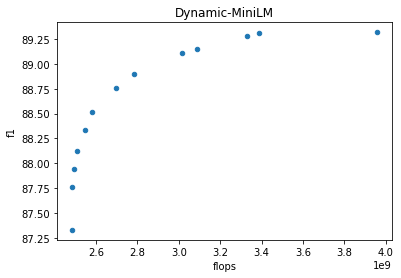

In [40]:
# plot pareto-graph found by evolutionary search, and select
# the best length-configuration (lc) within your computational budget

import matplotlib.pyplot as plt
import pandas as pd

cols=['lc', 'flops', 'f1','method', 'parents'] 
df=pd.read_csv('evo_search/parents-iter30.tsv',  names=cols, sep='\t', header=None)
df.plot(x ='flops', y='f1', kind = 'scatter', title='Dynamic-MiniLM')

constraint = 87.5 # not below 1%-loss of bert-base
best_lc = df[df["f1"] >= constraint].min()['lc']
print('best_lc: ' + str(best_lc))



# Dynamic MiniLM Benchmark

## Set benchmark parameters

In [8]:

EVAL_BATCH_SIZE = 16
model_output_dir = "./benchmark_results"


training_args = TrainingArguments(
    output_dir=model_output_dir,
    no_cuda=True,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    overwrite_output_dir=True
)



Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


## Dynamic-MiniLM performance

In [39]:
# load dynamic-minilm model

model_id = "sguskin/dynamic-minilmv2-L6-H384-squad1.1"

model_args = ModelArguments(
    model_name_or_path=model_id, 
)

set_seed(training_args.seed)

config = AutoConfig.from_pretrained(model_args.model_name_or_path)
model = RobertaForQuestionAnswering.from_pretrained(
    model_args.model_name_or_path,
    config=config
)
# model.resize_token_embeddings(len(tokenizer))

dynamic_trainer = QuestionAnsweringTrainer(
        model=model,
        args=training_args,
        train_dataset=roberta_train_dataset,
        eval_dataset=roberta_eval_dataset,
        eval_examples=roberta_eval_examples,
        tokenizer=roberta_tokenizer,
        data_collator=roberta_data_collator,
        post_process_function=post_processing_function,
        compute_metrics=compute_metrics
    )

dynamic_trainer.run_benchmark()


loading configuration file https://huggingface.co/sguskin/dynamic-minilmv2-L6-H384-squad1.1/resolve/main/config.json from cache at /nfs/site/home/sguskin/.cache/huggingface/transformers/a44461e990b9565b874f36efa632d10137ea10d6601ed9b20aac30d24f2a9f73.55d058ace8df1ff1081862f63663338c8e826cbc9617c9a914349e35c8de1d98
Model config RobertaConfig {
  "_name_or_path": "sguskin/dynamic-minilmv2-L6-H384-squad1.1",
  "architectures": [
    "RobertaForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.20.1",
  "type_vocab_siz

  0%|          | 0/10570 [00:00<?, ?it/s]

2022-07-31 02:18:04 [INFO] Saving predictions to ./benchmark_results/eval_predictions.json.
2022-07-31 02:18:04 [INFO] Saving nbest_preds to ./benchmark_results/eval_nbest_predictions.json.


Batch size = 16
Finally Eval eval_f1 Accuracy: 89.28118310884184
Latency: 42.47066985688019 ms
Throughput: 23.54566112024723 samples/sec
Duration: 458.2585277557373 sec
Latency: 16.216413071379066 ms
FLOPs: 4758553344 


/nfs/site/home/sguskin/anaconda3/lib/python3.8/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::ones". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/nfs/site/home/sguskin/anaconda3/lib/python3.8/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::expand". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/nfs/site/home/sguskin/anaconda3/lib/python3.8/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::unsqueeze". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/nfs/site/home/sguskin/anaconda3/lib/python3.8/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::cumsum". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/nfs/site/home/sguskin/anaconda3/lib/python3.8/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::type_as". Skipped.
  warnings.warn('No handlers

## Dynamic-MiniLM performance with best length-configuration found by evolutionary-search

In [41]:

dynamic_length_config = DynamicLengthConfig(
        length_config=best_lc
    )

# set sequence-lengths per each layer during evaluation
dynamic_trainer.set_dynamic_config(dynamic_length_config)

dynamic_trainer.run_benchmark()


2022-07-31 02:21:26 [INFO] The following columns in the evaluation set  don't have a corresponding argument in `RobertaForQuestionAnswering.forward` and have been ignored: example_id, offset_mapping.
***** Running Evaluation *****
  Num examples = 10790
  Batch size = 16


setting length config to - (269, 253, 252, 202, 104, 34)


  0%|          | 0/10570 [00:00<?, ?it/s]

2022-07-31 02:24:56 [INFO] Saving predictions to ./benchmark_results/eval_predictions.json.
2022-07-31 02:24:56 [INFO] Saving nbest_preds to ./benchmark_results/eval_nbest_predictions.json.


Batch size = 16
Finally Eval eval_f1 Accuracy: 87.76366630183897
Latency: 20.010042966682672 ms
Throughput: 49.97490518461306 samples/sec
Duration: 215.90836361050606 sec
Latency: 17.005792840694387 ms
FLOPs: 2485456896 


/nfs/site/home/sguskin/anaconda3/lib/python3.8/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::ones". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/nfs/site/home/sguskin/anaconda3/lib/python3.8/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::expand". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/nfs/site/home/sguskin/anaconda3/lib/python3.8/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::unsqueeze". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/nfs/site/home/sguskin/anaconda3/lib/python3.8/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::cumsum". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/nfs/site/home/sguskin/anaconda3/lib/python3.8/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::type_as". Skipped.
  warnings.warn('No handlers

## Baseline - BERT-Base performance

In [9]:
# load bert-base model

model_id = "sguskin/bert-base-uncased-squad1"

model_args = ModelArguments(
    model_name_or_path=model_id, 
)

set_seed(training_args.seed)

config = AutoConfig.from_pretrained(model_args.model_name_or_path)
model = AutoModelForQuestionAnswering.from_pretrained(
    model_args.model_name_or_path,
    config=config
)
# model.resize_token_embeddings(len(tokenizer))

bert_trainer = QuestionAnsweringTrainer(
        model=model,
        args=training_args,
        train_dataset=bert_train_dataset,
        eval_dataset=bert_eval_dataset,
        eval_examples=bert_eval_examples,
        tokenizer=bert_tokenizer,
        data_collator=bert_data_collator,
        post_process_function=post_processing_function,
        compute_metrics=compute_metrics
    )

bert_trainer.run_benchmark()


2022-07-31 03:34:15 [INFO] Lock 140397938227472 acquired on /nfs/site/home/sguskin/.cache/huggingface/transformers/4f73d77ab928c1e85c649317a03fb1d8bb17c4271c9925f77242cc5c8e8a2b6f.44e7e7e8a71d2128b2d7743552f49bbaa35ba4056ca5b61fc2c5c12edb3e4f48.lock


Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

2022-07-31 03:34:15 [INFO] Lock 140397938227472 released on /nfs/site/home/sguskin/.cache/huggingface/transformers/4f73d77ab928c1e85c649317a03fb1d8bb17c4271c9925f77242cc5c8e8a2b6f.44e7e7e8a71d2128b2d7743552f49bbaa35ba4056ca5b61fc2c5c12edb3e4f48.lock
2022-07-31 03:34:16 [INFO] Lock 140397938227472 acquired on /nfs/site/home/sguskin/.cache/huggingface/transformers/1827bd29e826845f5f0fb3ad61e3a61daf3820ffb6561b4d8eca942a23290198.5008df80b7b872551ce8e818b04ba991d932907cbd1f15ca3470239e0c2f9245.lock


Downloading:   0%|          | 0.00/415M [00:00<?, ?B/s]

2022-07-31 03:34:26 [INFO] Lock 140397938227472 released on /nfs/site/home/sguskin/.cache/huggingface/transformers/1827bd29e826845f5f0fb3ad61e3a61daf3820ffb6561b4d8eca942a23290198.5008df80b7b872551ce8e818b04ba991d932907cbd1f15ca3470239e0c2f9245.lock
2022-07-31 03:34:31 [INFO] The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
***** Running Evaluation *****
  Num examples = 10784
  Batch size = 16


  0%|          | 0/10570 [00:00<?, ?it/s]

2022-07-31 03:55:36 [INFO] Saving predictions to ./benchmark_results/eval_predictions.json.
2022-07-31 03:55:36 [INFO] Saving nbest_preds to ./benchmark_results/eval_nbest_predictions.json.


Batch size = 16
Finally Eval eval_f1 Accuracy: 88.94360518627263
Latency: 117.84504024522278 ms
Throughput: 8.485719873480532 samples/sec
Duration: 1270.8409140044823 sec
Latency: 51.25485342927277 ms
FLOPs: 35340779904 


/nfs/site/home/sguskin/anaconda3/lib/python3.8/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::ones". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/nfs/site/home/sguskin/anaconda3/lib/python3.8/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::expand". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/nfs/site/home/sguskin/anaconda3/lib/python3.8/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::unsqueeze". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/nfs/site/home/sguskin/anaconda3/lib/python3.8/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::permute". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/nfs/site/home/sguskin/anaconda3/lib/python3.8/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::gelu". Skipped.
  warnings.warn('No handlers f

# Static Post Training Quantization

In [14]:
# load dynamic-minilm model

model_id = "sguskin/dynamic-minilmv2-L6-H384-squad1.1"

model_args = ModelArguments(
    model_name_or_path=model_id, 
)

set_seed(training_args.seed)

config = AutoConfig.from_pretrained(model_args.model_name_or_path)
model = RobertaForQuestionAnswering.from_pretrained(
    model_args.model_name_or_path,
    config=config
)
# model.resize_token_embeddings(len(tokenizer))

quant_dynamic_trainer = QuestionAnsweringTrainer(
        model=model,
        args=training_args,
        train_dataset=roberta_train_dataset,
        eval_dataset=roberta_eval_dataset,
        eval_examples=roberta_eval_examples,
        tokenizer=roberta_tokenizer,
        data_collator=roberta_data_collator,
        post_process_function=post_processing_function,
        compute_metrics=compute_metrics
    )


tune_metric = metrics.Metric(
    name="eval_f1", # Metric used for the tuning strategy.
    is_relative=True, # Metric tolerance mode, True is for relative, otherwise for absolute.
    criterion="0.01", # Performance tolerance when optimizing the model.
)
quantization_config = QuantizationConfig(
    approach="PostTrainingStatic",
    max_trials=200,
    metrics=[tune_metric],
)

# lc = "(269, 253, 252, 202, 104, 34)" # configure model with best length config

# dynamic_length_config = DynamicLengthConfig(
#         length_config=lc
# )
# quant_dynamic_trainer.set_dynamic_config(dynamic_length_config)


# run quantization
quant_dynamic_trainer.quantize(quant_config=quantization_config)

loading configuration file https://huggingface.co/sguskin/dynamic-minilmv2-L6-H384-squad1.1/resolve/main/config.json from cache at /nfs/site/home/sguskin/.cache/huggingface/transformers/a44461e990b9565b874f36efa632d10137ea10d6601ed9b20aac30d24f2a9f73.55d058ace8df1ff1081862f63663338c8e826cbc9617c9a914349e35c8de1d98
Model config RobertaConfig {
  "_name_or_path": "sguskin/dynamic-minilmv2-L6-H384-squad1.1",
  "architectures": [
    "RobertaForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.20.1",
  "type_vocab_siz

  0%|          | 0/10570 [00:00<?, ?it/s]

2022-07-31 04:27:25 [INFO] Saving predictions to ./finetuned_minilm/eval_predictions.json.
2022-07-31 04:27:25 [INFO] Saving nbest_preds to ./finetuned_minilm/eval_nbest_predictions.json.
2022-07-31 04:27:30 [INFO] {
2022-07-31 04:27:30 [INFO]     'eval_exact_match': 81.90160832544939,
2022-07-31 04:27:30 [INFO]     'eval_f1': 89.28118310884184
2022-07-31 04:27:30 [INFO] }
2022-07-31 04:27:30 [INFO] metric: 89.28118310884184
2022-07-31 04:27:30 [INFO] Throughput: None samples/sec
2022-07-31 04:27:30 [INFO] Save tuning history to /ec/pdx/disks/mlp_lab_home_pool_02/sguskin/dynamic/frameworks.ai.intel-extension-for-transformers.intel-intel-extension-for-transformers/docs/tutorials/pytorch/question-answering/nc_workspace/2022-07-31_03-23-24/./history.snapshot.
2022-07-31 04:27:30 [INFO] FP32 baseline is: [Accuracy: 89.2812, Duration (seconds): 205.1094]
2022-07-31 04:27:30 [INFO] Fx trace of the entire model failed, We will conduct auto quantization
2022-07-31 04:27:31 [WARNING] Please not

AttributeError: 'NoneType' object has no attribute 'quantized_state_dict'

## Run Benchmark after Static Post Training Quantization

In [17]:
quant_dynamic_trainer.run_benchmark()


2022-07-31 01:40:29 [INFO] The following columns in the evaluation set  don't have a corresponding argument in `RobertaForQuestionAnswering.forward` and have been ignored: example_id, offset_mapping.
***** Running Evaluation *****
  Num examples = 10790
  Batch size = 1


  0%|          | 0/10570 [00:00<?, ?it/s]

2022-07-31 01:45:48 [INFO] Saving predictions to ./benchmark_results/eval_predictions.json.
2022-07-31 01:45:48 [INFO] Saving nbest_preds to ./benchmark_results/eval_nbest_predictions.json.


Batch size = 1
Finally Eval eval_f1 Accuracy: 87.26878045524857
Latency: 30.149574108521925 ms
Throughput: 33.167964376562956 samples/sec
Duration: 325.3139046309516 sec
Latency: 23.48242442123592 ms
FLOPs: 2485456896 


/nfs/site/home/sguskin/anaconda3/lib/python3.8/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::ones". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/nfs/site/home/sguskin/anaconda3/lib/python3.8/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::expand". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/nfs/site/home/sguskin/anaconda3/lib/python3.8/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::unsqueeze". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/nfs/site/home/sguskin/anaconda3/lib/python3.8/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::cumsum". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/nfs/site/home/sguskin/anaconda3/lib/python3.8/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::type_as". Skipped.
  warnings.warn('No handlers